In [1]:
# @title Setup

competition = "PM2.5"  # @param
# @markdown ---

from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

competition_id = "super-ai-engineer-5-pm-2-5-data-of-thailand"
!kaggle competitions download -c {competition_id}
!unzip /content/{competition_id}.zip

Archive:  /content/super-ai-engineer-5-pm-2-5-data-of-thailand.zip
  inflating: sample_submission.csv   
  inflating: train.csv               


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
df = pd.read_csv('/content/train.csv')
df = df[:-1]
df.ffill(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,PM2.5
0,2013-01-01,26.0
1,2013-01-02,21.0
2,2013-01-03,21.0
3,2013-01-04,20.0
4,2013-01-05,22.0


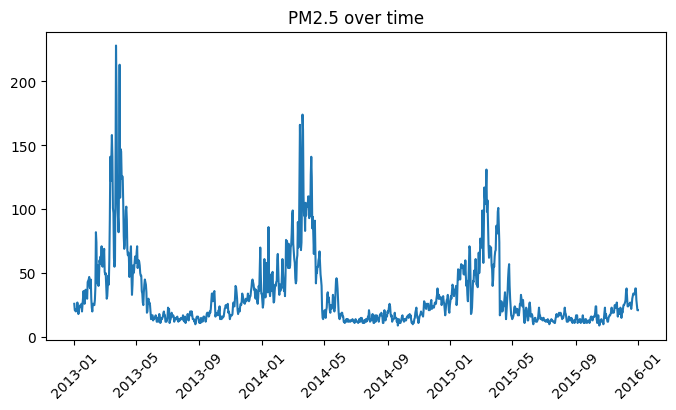

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['PM2.5'])
plt.xticks(rotation=45)
plt.title("PM2.5 over time")
plt.show()

## EDA

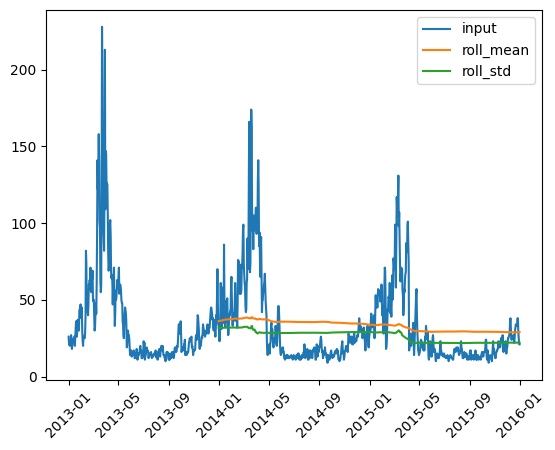

In [5]:
def plot_stationary(df, lags=3):
    temp = df.copy()
    temp.set_index('Date', inplace=True)
    temp['roll_mean'] = temp['PM2.5'].rolling(lags).mean()
    temp['roll_std'] = temp['PM2.5'].rolling(lags).std()

    plt.plot(temp['PM2.5'], label='input')
    plt.plot(temp['roll_mean'], label='roll_mean')
    plt.plot(temp['roll_std'], label='roll_std')
    plt.xticks(rotation=45)
    plt.legend()


plot_stationary(df, 365)

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] <= 0.05:
        print("Conclusion: Data is stationary (reject H0)")
    else:
        print("Conclusion: Data is NOT stationary (fail to reject H0)")

adf_test(df['PM2.5'])

ADF Statistic: -3.1024549194228506
p-value: 0.0263720460750232
Critical Values: {'1%': np.float64(-3.4364647646486093), '5%': np.float64(-2.864239892228526), '10%': np.float64(-2.5682075189699822)}
Conclusion: Data is stationary (reject H0)


## Data Prep

In [7]:
filtered_df = df[df['Date'] > '2013-12-31'].reset_index(drop=True)
filtered_df.head()

,Date,PM2.5
0,2014-01-01,28.0
1,2014-01-02,23.0
2,2014-01-03,26.0
3,2014-01-04,36.0
4,2014-01-05,61.0


In [48]:
data = df['PM2.5'].values.reshape(-1, 1)
SEQUENCE_LENGTH = 365

X, y = [], []
for i in range(SEQUENCE_LENGTH, len(data)):
    X.append(data[i-SEQUENCE_LENGTH:i])
    y.append(data[i])

X = np.array(X)  # Shape: (num_samples, 365, 1)
y = np.array(y)  # Shape: (num_samples, 1)

# --- Train/Test Split ---
SPLIT = int(len(X) * 0.8)
X_train, X_val = X[:SPLIT], X[SPLIT:]
y_train, y_val = y[:SPLIT], y[SPLIT:]
X_train.shape, X_val.shape

((584, 365, 1), (146, 365, 1))

## Model Training

In [49]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential(name='Bi_LSTM')
model.add(Input(shape=(365, 1)))

model.add( Bidirectional(LSTM(128, return_sequences=False)) )
model.add(Dropout(0.5))

model.add(Dense(16))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse',)
model.summary()

Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 256)                 │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,249 (536.13 KB)

 Trainable params: 137,249 (536.13 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=256,
                    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
                    verbose=1)

loss = model.evaluate(X, y)
print(f"Test Loss: {loss:.4f}")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 1944.5200 - val_loss: 265.8274
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1823.5000 - val_loss: 193.1863
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1615.7928 - val_loss: 133.9419
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1574.3080 - val_loss: 89.2305
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1399.7823 - val_loss: 61.7219
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1272.1270 - val_loss: 52.6957
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1282.2765 - val_loss: 59.7755
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1221.6746 - val_loss: 75.7948
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 998.0522 - val_loss: 91.7899
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1012.8268 - val_loss: 104.5105
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 869.1351 - val_loss: 108.8409
Epoch 12/100
3/3 ━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


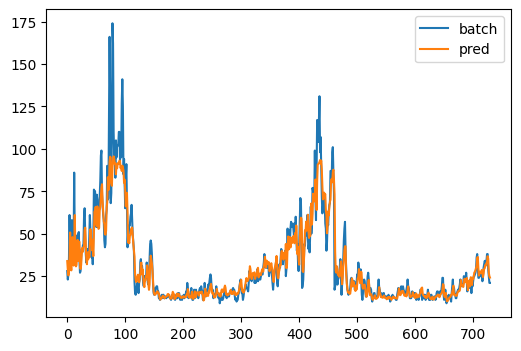

In [51]:
pred = model.predict(X)

plt.figure(figsize=(6, 4))
plt.plot(y, label='batch')
plt.plot(pred, label='pred')
plt.legend()
plt.show()

## Predictions

100%|██████████| 366/366 [00:31<00:00, 11.60it/s]


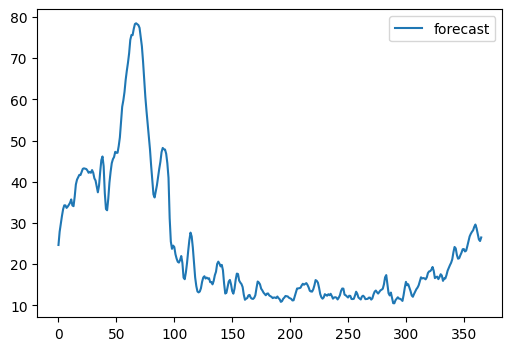

In [52]:
last_sequence = data[-365:]
forecast_input = last_sequence.reshape(1, 365, 1)

predictions = []

for _ in tqdm(range(366)):
    next_pred = model.predict(forecast_input, verbose=False)[0][0]
    predictions.append(next_pred)

    forecast_input = np.append(forecast_input[:, 1:, :], [[[next_pred]]], axis=1)

plt.figure(figsize=(6, 4))
plt.plot(predictions, label='forecast')
plt.legend()

## Submission

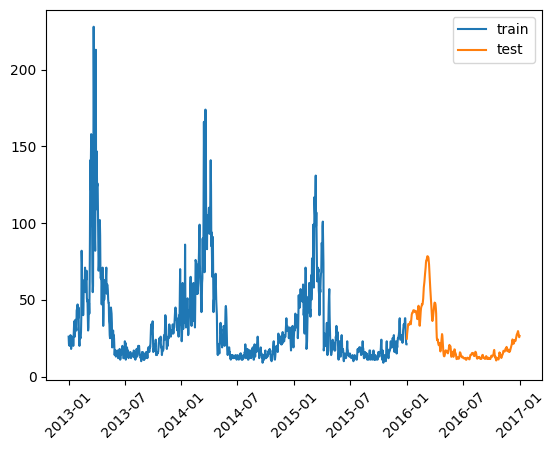

In [54]:
submission = pd.read_csv('sample_submission.csv')
submission['PM2.5'] = predictions

plt.plot(df['Date'], df['PM2.5'], label='train')
plt.plot(pd.to_datetime(submission['Date'], format='%d/%m/%Y'), submission['PM2.5'], label='test')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [55]:
submission.to_csv('LSTM_late_3.csv', index=False)

**Legacy**

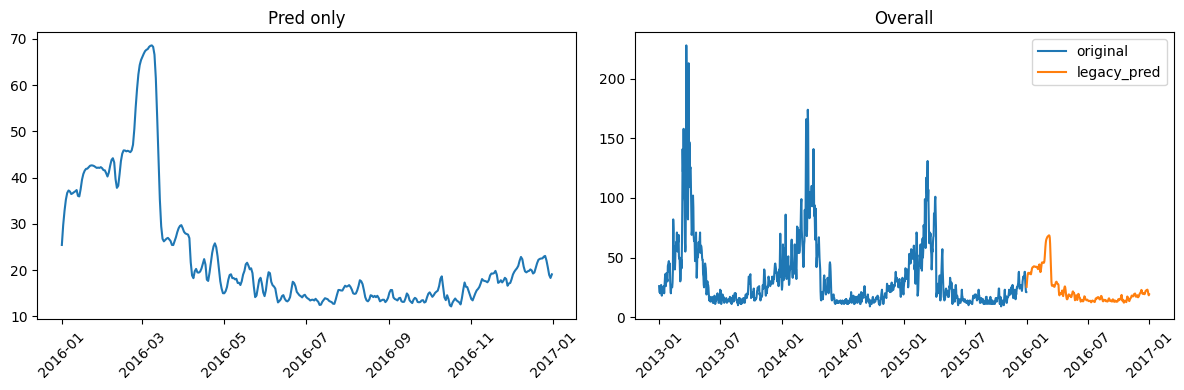

In [33]:
legacy = pd.read_csv('/content/LSTM-Dense_2014-2015.csv')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(legacy['Date'], format='%d/%m/%Y'), legacy['PM2.5'],)
plt.title('Pred only')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(df['Date'], df['PM2.5'], label='original')
plt.plot(pd.to_datetime(legacy['Date'], format='%d/%m/%Y'), legacy['PM2.5'], label='legacy_pred')
plt.title('Overall')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()